In [1]:
from __future__ import division
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from skin_data.data_loader.loader import *
import glob
import numpy as np
import copy
import yaml
import argparse
from sklearn.metrics import f1_score
from tqdm import tqdm
from model.vit_seg_modeling import VisionTransformer as ViT_seg
from model.vit_seg_modeling import CONFIGS as CONFIGS_ViT_seg
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from matplotlib import pyplot as plt
%matplotlib inline
from scipy.ndimage import binary_fill_holes, binary_opening
from PIL import Image
from model.MaxViT_deform_LKA import MaxViT_deformableLKAFormer
from model.swinunet.vision_transformer import SwinUnet
from model.swinunet.config import get_config
from torchvision.utils import save_image
from model.hiformer.HiFormer import HiFormer
from model.hiformer.HiFormer_configs import get_hiformer_b_configs
import torch

/home/ubuntu/anaconda3/envs/medFormer/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--root_path', type=str,
                    default='./skin_data/ISIC-2018_npy/', help='root dir for data')
parser.add_argument('--dataset', type=str,
                    default='isic2018', help='experiment_name')

parser.add_argument('--list_dir', type=str,
                    default='./lists/lists_Synapse', help='list dir')
parser.add_argument('--num_classes', type=int,
                    default=9, help='output channel of network')
parser.add_argument('--max_iterations', type=int,
                    default=30000, help='maximum epoch number to train')
parser.add_argument('--max_epochs', type=int,
                    default=100, help='maximum epoch number to train')
parser.add_argument('--batch_size', type=int,
                    default=24, help='batch_size per gpu')
parser.add_argument('--n_gpu', type=int, default=1, help='total gpu')
parser.add_argument('--deterministic', type=int,  default=1,
                    help='whether use deterministic training')
parser.add_argument('--base_lr', type=float,  default=0.01,
                    help='segmentation network learning rate')
parser.add_argument('--img_size', type=int,
                    default=224, help='input patch size of network input')
parser.add_argument('--seed', type=int,
                    default=1234, help='random seed')
parser.add_argument('--n_skip', type=int,
                    default=3, help='using number of skip-connect, default is num')
parser.add_argument('--vit_name', type=str,
                    default='R50-ViT-B_16', help='select one vit model')
parser.add_argument('--vit_patches_size', type=int,
                    default=16, help='vit_patches_size, default is 16')

parser.add_argument('--is_pretrain', default=False, type=bool, help='Use pretraining or not.')
parser.add_argument(
        "--opts",
        help="Modify config options by adding 'KEY VALUE' pairs. ",
        default=None,
        nargs='+',
    )
parser.add_argument('--zip', action='store_true', help='use zipped dataset instead of folder dataset')
parser.add_argument('--cache-mode', type=str, default='part', choices=['no', 'full', 'part'],
                    help='no: no cache, '
                            'full: cache all data, '
                            'part: sharding the dataset into nonoverlapping pieces and only cache one piece')
parser.add_argument('--resume', help='resume from checkpoint')
parser.add_argument('--accumulation-steps', type=int, help="gradient accumulation steps")
parser.add_argument('--use-checkpoint', action='store_true',
                    help="whether to use gradient checkpointing to save memory")
parser.add_argument('--amp-opt-level', type=str, default='O1', choices=['O0', 'O1', 'O2'],
                    help='mixed precision opt level, if O0, no amp is used')
parser.add_argument('--tag', help='tag of experiment')
parser.add_argument('--eval', action='store_true', help='Perform evaluation only')
parser.add_argument('--throughput', action='store_true', help='Test throughput only')

# args = parser.parse_args()
args = parser.parse_args(args=[])

In [3]:
## Hyper parameters
# config         = yaml.load(open('./config_skin.yml'), Loader=yaml.FullLoader)
number_classes = 1
input_channels = 3
best_val_loss  = np.inf
patience       = 0
device = 'cuda' if torch.cuda.is_available() else 'cpu'

data_path = args.root_path

test_dataset = isic_loader(path_Data = data_path, train = False, Test = True)
test_loader  = DataLoader(test_dataset, batch_size = 1, shuffle= False)


In [4]:
random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
dataset_name = args.dataset
dataset_config = {
    'Synapse': {
        'root_path': '',
        'list_dir': '',
        'num_classes': 1,
    },
}
args.num_classes = 1
args.root_path = ''
args.list_dir = ''
args.exp = 'MaxViT-' + dataset_name + str(args.img_size)
snapshot_path = "./model_out/results/{}/{}".format(args.exp, 'model')
snapshot_path = snapshot_path + '_pretrain' if args.is_pretrain else snapshot_path
snapshot_path = snapshot_path+'_'+str(args.max_iterations)[0:2]+'k' if args.max_iterations != 30000 else snapshot_path
snapshot_path = snapshot_path + '_epo' +str(args.max_epochs) if args.max_epochs != 30 else snapshot_path
snapshot_path = snapshot_path+'_bs'+str(args.batch_size)
snapshot_path = snapshot_path + '_lr' + str(args.base_lr) if args.base_lr != 0.01 else snapshot_path
snapshot_path = snapshot_path + '_imgsize'+str(args.img_size)
snapshot_path = snapshot_path + '_s'+str(args.seed) if args.seed!=1234 else snapshot_path

config_vit = CONFIGS_ViT_seg[args.vit_name]
config_vit.n_classes = args.num_classes
config_vit.n_skip = args.n_skip
if args.vit_name.find('R50') != -1:
    config_vit.patches.grid = (int(args.img_size / args.vit_patches_size), int(args.img_size / args.vit_patches_size))

Net = MaxViT_deformableLKAFormer(img_size=args.img_size, num_classes=1).to(device)
Net.load_state_dict(torch.load('./model_out/model_results2018/MaxViT_isic2018224/model_epo100_bs4_lr0.01_imgsize224_s1234/best_model.pth',
                                map_location='cpu')['model_weights'])


/home/ubuntu/anaconda3/envs/medFormer/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1678411187366/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


<All keys matched successfully>

## Quntitative performance

In [5]:
predictions = []
gt = []
best_dsc = 0
best_opening = 0
best_closing = 0
for opening_size in range(6,7):
    for fill_size in range(6,7):
        with torch.no_grad():
            print('val_mode')
            val_loss = 0
            Net.eval()
            for itter, batch in tqdm(enumerate(test_loader)):
                img = batch['image'].to(device, dtype=torch.float)
                msk = batch['mask']
                msk_pred = Net(img)

                gt.append(msk.numpy()[0, 0])
                msk_pred = msk_pred.cpu().detach().numpy()[0, 0]
                msk_pred  = np.where(msk_pred>=0.5, 1, 0)
                msk_pred = binary_opening(msk_pred, structure=np.ones((opening_size,opening_size))).astype(msk_pred.dtype)
                msk_pred = binary_fill_holes(msk_pred, structure=np.ones((fill_size,fill_size))).astype(msk_pred.dtype)
                predictions.append(msk_pred)        
                
                # save img, mask_gt, mask_pred
                out_folder = snapshot_path +'/'+ str(itter + 1) 
                if not os.path.exists(out_folder):
                    os.makedirs(out_folder)
                #print(msk_pred.dtype)
                
                zero_one_image = img[0] / 255.0
                save_image(zero_one_image, out_folder + '/img_' + str(itter + 1) + '.png')
                save_image(msk[0], out_folder + '/gt_' + str(itter + 1) + '.png')
                msk_pred_tensor = torch.from_numpy(msk_pred).float()
                save_image(msk_pred_tensor, out_folder + '/pred_' + str(itter + 1) + '.png')
                
                
        predictions = np.array(predictions)
        gt = np.array(gt)

        y_scores = predictions.reshape(-1)
        y_true   = gt.reshape(-1)

        y_scores2 = np.where(y_scores>0.47, 1, 0)
        y_true2   = np.where(y_true>0.5, 1, 0)

        print("Opening kernel: {} | Filling Kernel {}".format(opening_size, fill_size))
        #F1 score
        F1_score = f1_score(y_true2, y_scores2, labels=None, average='binary', sample_weight=None)
        print ("\nF1 score (F-measure) or DSC: " +str(F1_score))
        confusion = confusion_matrix(np.int32(y_true), y_scores2)
        #print (confusion)
        accuracy = 0
        if float(np.sum(confusion))!=0:
            accuracy = float(confusion[0,0]+confusion[1,1])/float(np.sum(confusion))
        print ("Accuracy: " +str(accuracy))
        specificity = 0
        if float(confusion[0,0]+confusion[0,1])!=0:
            specificity = float(confusion[0,0])/float(confusion[0,0]+confusion[0,1])
        print ("Specificity: " +str(specificity))
        sensitivity = 0
        if float(confusion[1,1]+confusion[1,0])!=0:
            sensitivity = float(confusion[1,1])/float(confusion[1,1]+confusion[1,0])
        print ("Sensitivity: " +str(sensitivity))
        predictions = []
        gt = []
        # save best dsc
        if F1_score > best_dsc:
            print(f"New best dsc: {F1_score}")
            best_dsc = F1_score
            best_opening = opening_size
            best_closing = fill_size
            
print(f"Best DSC: {best_dsc}, achieved with opening kernel size {best_opening} and closing size {best_closing}.")




val_mode


520it [01:01,  8.43it/s]


Opening kernel: 6 | Filling Kernel 6

F1 score (F-measure) or DSC: 0.8883398375703898
Accuracy: 0.957185629660518
Specificity: 0.9784339341333808
Sensitivity: 0.8705776588714128
New best dsc: 0.8883398375703898
Best DSC: 0.8883398375703898, achieved with opening kernel size 6 and closing size 6.


## Visualization section

In [6]:
def save_sample(img, msk, msk_pred, th=0.3, name=''):
    img2 = img.detach().cpu().numpy()[0]
    img2 = np.einsum('kij->ijk', img2)
    msk2 = msk.detach().cpu().numpy()[0,0]
    mskp = msk_pred.detach().cpu().numpy()[0,0]
    msk2 = np.where(msk2>0.5, 1., 0)
    mskp = np.where(mskp>=th, 1., 0)

    plt.figure(figsize=(7,15))

    plt.subplot(3,1,1)
    plt.imshow(img2/255.)
    plt.axis('off')

    plt.subplot(3,1,2)
    plt.imshow(msk2*255, cmap= 'gray')
    plt.axis('off')

    plt.subplot(3,1,3)
    plt.imshow(mskp*255, cmap = 'gray')
    plt.axis('off')

    plt.savefig('./check_results/'+name+'.png')


val_mode


4it [00:01,  3.09it/s]


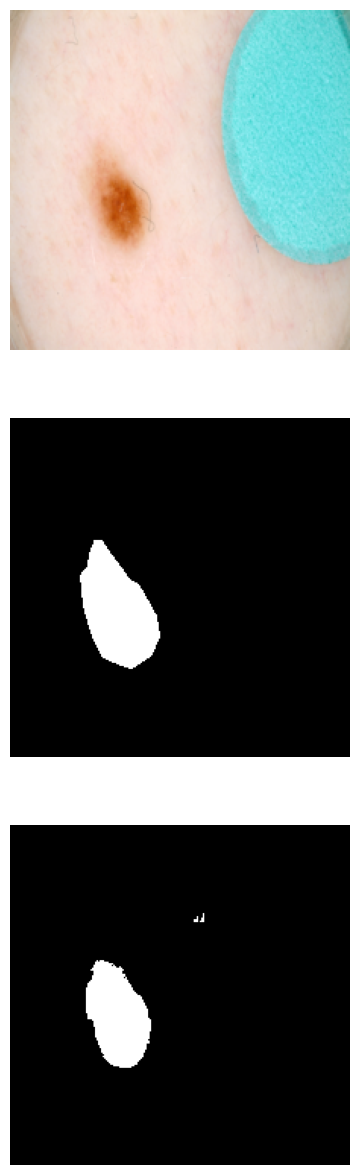

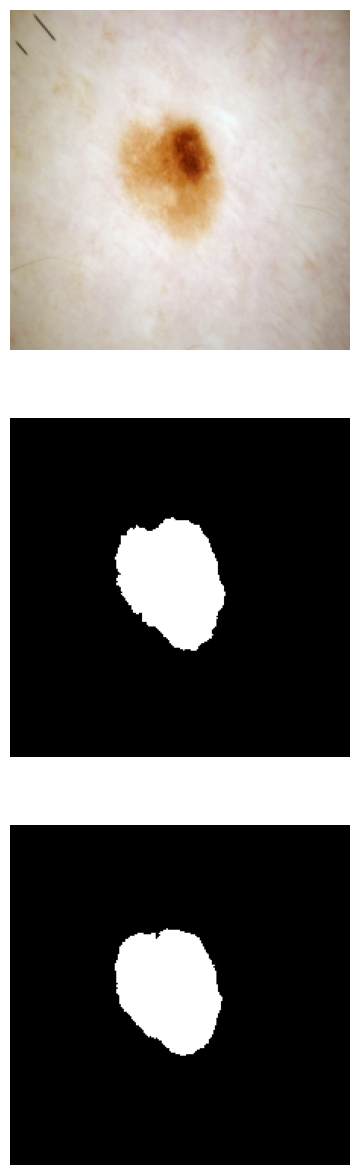

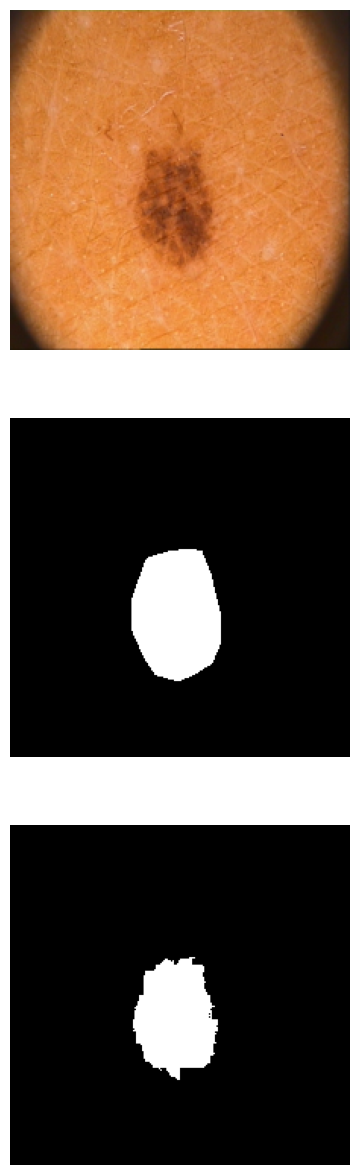

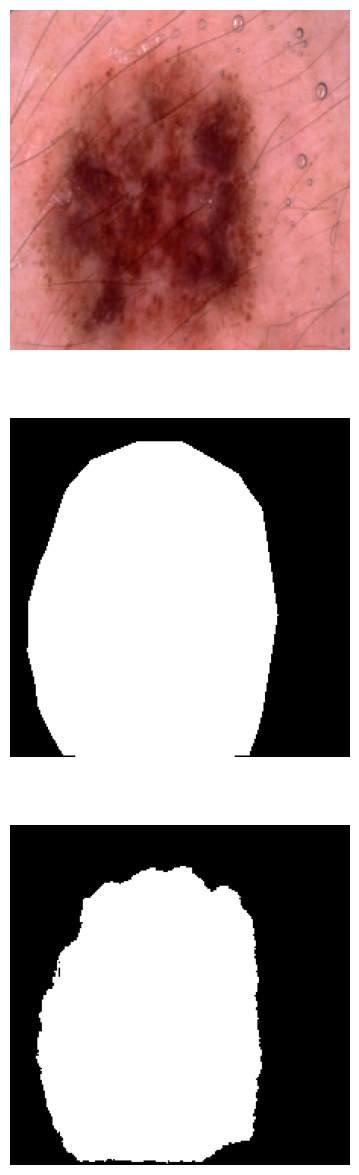

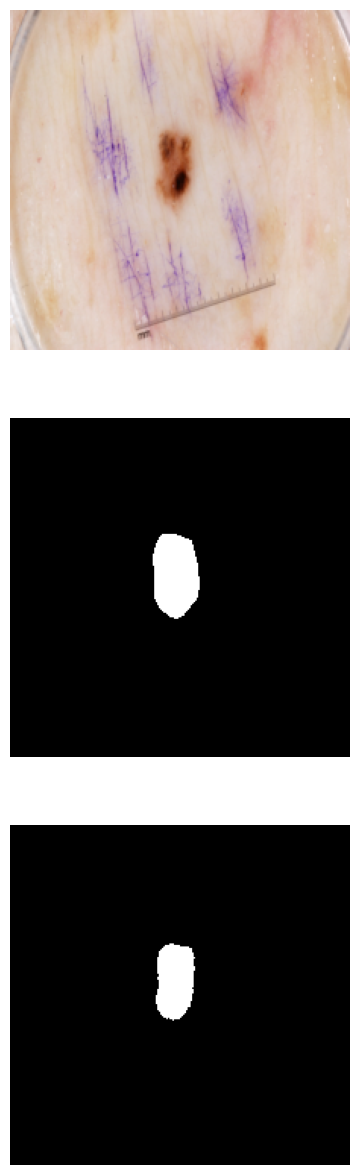

In [7]:
predictions = []
gt = []

N = 5 ## Number of samples to visualize
with torch.no_grad():
    print('val_mode')
    val_loss = 0
    Net.eval()
    for itter, batch in tqdm(enumerate(test_loader)):
        img = batch['image'].to(device, dtype=torch.float)
        msk = batch['mask']
        msk_pred = Net(img)
        
        gt.append(msk.numpy())
        predictions.append(msk_pred.cpu().detach().numpy())
        save_sample(img, msk, msk_pred, th=0.5, name=str(itter+1))
        if itter+1==N:
            break
            